# 目的与意义

## 背景

nifH 基因是研究生物固氮功能的重要标记基因。通过分析该基因的序列特征（如 GC 含量、序列长度等），可以评估其功能活跃性或丰度。这对于理解海洋生态系统中的氮循环具有重要意义。

## 研究目的

1. 探索 nifH 基因的关键特征与功能活跃性之间的关系。
2. 使用机器学习模型（线性回归、随机森林、神经网络），预测未知样本的固氮功能。
3. 比较不同模型的性能，评估其在生物信息学分析中的适用性。

## 意义

通过引入模型方法，可以：

1. 提高固氮基因功能预测的准确性，扩展其应用场景。
2. 捕捉复杂的特征关系，为未来基因功能研究提供参考。
3. 构建一个通用的分析框架，为其他基因功能分析提供方法论支持。


## ID：基因序列的唯一标识符。

## Sequence：基因的碱基序列（A、T、C、G）。

## Length：基因的长度，单位为碱基对。

## GC_Content：GC 含量，是 (G + C) / 总长度。


In [2]:
import sys
print(sys.version)

3.9.18 (main, Sep 11 2023, 08:38:23) 
[Clang 14.0.6 ]


In [37]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import math

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score ,classification_report,ConfusionMatrixDisplay
from collections import Counter
from Bio import SeqIO
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV


<!-- 是一个典型的 nifH 基因序列长度范围，GC 含量为 0.646，符合固氮基因常见的高 GC 含量特性。 -->


In [4]:
# 定义主数据文件夹路径
data_folder = "./nifHdata"

# 存储所有序列的列表
all_sequences = []

# 标签，每个基因组的标签
all_labels = []

all_annotations = []  # 存储注释信息

In [5]:
# 遍历20个文件夹
# 遍历20个文件夹
for i in range(20):
    folder_name = f"nifH_datasets ({i})" if i > 0 else "nifH_datasets"
    folder_path = os.path.join(data_folder, folder_name)
    gene_file = os.path.join(folder_path, "ncbi_dataset/data/gene.fna")
    
    # 确保文件存在
    if os.path.exists(gene_file):
        # 读取 fasta 文件中的序列和注释信息
        for record in SeqIO.parse(gene_file, "fasta"):
            all_sequences.append(str(record.seq))  # 转换为字符串存储
            all_annotations.append(record.description)  # 存储注释信息
            all_labels.append(i)  # 标签对应文件夹编号
    else:
        print(f"can not find file：{gene_file}")


# 打印结果
print(f"successfully load {len(all_sequences)} 条序列！")
print(f"共有 {len(set(all_labels))} 个类别，标签为：{set(all_labels)}")
print("示例序列：", all_sequences[0][:50], "...")  # 只显示第一条序列前 50 个字符
print("示例注释：", all_annotations[0])  # 显示第一条序列的注释信息
print("示例标签：", all_labels[0])  # 显示第一条序列的标签


successfully load 20 条序列！
共有 20 个类别，标签为：{0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19}
示例序列： ATGTCTTTGCGCCAGATTGCGTTCTACGGTAAGGGCGGTATCGGCAAGTC ...
示例注释： NZ_VISK01000015.1:262164-263045 nifH [organism=Azospirillum brasilense] [GeneID=56451760] [chromosome=]
示例标签： 0


In [6]:
print(all_sequences)

['ATGTCTTTGCGCCAGATTGCGTTCTACGGTAAGGGCGGTATCGGCAAGTCCACCACCTCCCAGAACACCCTGGCCGCGCTGGTCGAGCTGGATCAGAAGATCCTGATCGTCGGCTGCGATCCGAAGGCCGACTCGACCCGCCTGATCCTGCACGCCAAGGCGCAGGACACCGTGCTGCACCTCGCCGCCGAAGCCGGCTCGGTCGAGGATCTGGAGCTCGAGGACGTTCTCAAGATCGGCTACAAGGGCATCAAGTGCGTCGAGTCCGGCGGTCCGGAGCCGGGGGTCGGCTGCGCCGGCCGCGGCGTGATCACCTCGATCAACTTCCTGGAAGAGAACGGCGCCTACGACGACGTGGACTACGTCTCCTACGACGTGCTGGGCGACGTGGTGTGCGGCGGTTTCGCCATGCCCATCCGCGAGAACAAGGCCCAGGAAATCTACATCGTCATGTCCGGTGAGATGATGGCGCTCTACGCCGCCAACAACATCGCCAAGGGCATTCTGAAGTACGCCCACAGCGGCGGCGTGCGCCTCGGCGGCCTGATCTGCAACGAGCGCCAGACCGACAAGGAAATCGACCTCGCCTCCGCCCTGGCCGCCCGCCTCGGCACCCAGCTCATCCACTTCGTGCCGCGCGACAACATCGTGCAGCACGCCGAGCTGCGCCGCATGACGGTGATCGAGTACGCGCCGGACAGCCAGCAGGCCCAGGAATACCGCCAGCTCGCCAACAAGGTCCACGCGAACAAGGGCAAGGGCACCATCCCGACCCCGATCACGATGGAAGAGCTGGAAGAGATGCTGATGGACTTCGGCATCATGAAGTCGGAGGAGCAGCAGCTCGCCGAGCTCCAGGCCAAGGAAGCCGCCAAGGCCTGA', 'ATGAGACAGGTAGCAATATATGGAAAAGGCGGTATAGGAAAATCCACTACAACCCAGAACACGGTGGCAGCGTTGGCCGAAGCAGGAAAAAAGGTCATGGTGGTAGGATGCG

# Directly convert these original sequences into One-hot encoding

### The main reason for converting the original sequence into one-hot encoding is to represent the gene sequence in a numerical form that can be understood by computers while retaining biological information.

The original gene sequence is composed of characters (such as A, T, G, C, etc.), which cannot be processed directly by computers. Before modeling, these characters need to be converted into numerical form, and One-hot encoding is a common representation method that can retain the information of each base in the original sequence.


In [7]:
import numpy as np

# 定义 One-hot 编码函数
def one_hot_encode(seq, max_length):
    mapping = {'A': 0, 'T': 1, 'G': 2, 'C': 3, 'N': 4}  # 碱基映射
    one_hot = np.zeros((max_length, len(mapping)), dtype=np.float32)
    for i, char in enumerate(seq[:max_length]):  # 限制最大长度
        if char in mapping:
            one_hot[i, mapping[char]] = 1
    return one_hot

# Calculate the length of each sequence （计算每条序列的长度）


In [8]:

# 获取所有序列的最大长度
max_length = max(len(seq) for seq in all_sequences)

# 转换所有序列为 One-hot 编码
encoded_sequences = np.array([one_hot_encode(seq, max_length) for seq in all_sequences])
encoded_labels = np.array(all_labels, dtype=np.int32)

# 打印编码结果
print(f"One-hot 编码完成！总样本数：{encoded_sequences.shape[0]}")
print(f"每条序列的编码形状：{encoded_sequences.shape[1:]}")  # 例如 (max_length, 5)
print(f"标签形状：{encoded_labels.shape}")


One-hot 编码完成！总样本数：20
每条序列的编码形状：(894, 5)
标签形状：(20,)


In [9]:
from sklearn.model_selection import train_test_split

# 划分数据集
train_data, test_data, train_labels, test_labels = train_test_split(
    encoded_sequences, encoded_labels, test_size=0.2, random_state=42
)

# 打印数据划分结果
print(f"训练集样本数：{train_data.shape[0]}")
print(f"测试集样本数：{test_data.shape[0]}")
print(f"每条序列的形状：{train_data.shape[1:]}")
print(f"标签形状：训练集：{train_labels.shape}，测试集：{test_labels.shape}")


训练集样本数：16
测试集样本数：4
每条序列的形状：(894, 5)
标签形状：训练集：(16,)，测试集：(4,)


In [ ]:
from Bio.Seq import Seq

# 送检序列
query_sequence = Seq("""
CTCCACTCGTCTGCTGCTCGGTGGACTGGCCCAGAAATCTGTACTTGATACTCTGCGGGAAGAAGGTGAGGACGTTGAACTCGACGATATCAGAAAAGCAGCTTACGGAGGAACCTGGGCAGTTGAATCAGGTGGCCCGGAGCCGGGTGTTGGCTGTGCAGGCCGAGGTATCATAACCGCGATTAACATGCTTGAATCCCTTGGCGCCTATGAGGAGAGCGAAAGCCTTGACTACGCCTTCTATGATGTTCTCGGTGATGTTGTTTGCGGTGGTTTTGCCATGCCCATCAGAGATGGTAAGGCGGAAGAAATCTATATCGTTGTCTCA
""".strip())

# 20 个样本序列
# print(all_sequences)

# 最小匹配长度
min_length = 11

def find_and_count_repeats(query_sequence, reference_sequences, min_length=5):
    """
    统计送检序列与参考序列之间的匹配片段数量，并返回匹配片段
    :param query_sequence: 送检序列
    :param reference_sequences: 参考序列列表
    :param min_length: 每次截取的长度（默认为 5）
    :return: 每个参考序列匹配片段的数量和匹配的片段列表
    """
    # 结果存储每个样本的匹配数量和匹配片段
    match_details = []

    # 遍历每个参考序列
    for ref_idx, reference_sequence in enumerate(reference_sequences):
        match_count = 0
        matched_fragments = set()  # 使用集合避免重复记录相同片段

        # 遍历送检序列，以步长为 1 滑动窗口截取 min_length 长度的片段
        for i in range(len(query_sequence) - min_length + 1):
            query_fragment = str(query_sequence[i:i + min_length])  # 将片段转换为字符串
            
            # 如果片段在参考序列中，记录匹配
            if query_fragment in reference_sequence:
                match_count += 1
                matched_fragments.add(query_fragment)

        # 保存匹配数量和匹配片段
        match_details.append((match_count, list(matched_fragments)))

    return match_details

# 调用函数计算匹配数量和片段
results = find_and_count_repeats(query_sequence, all_sequences, min_length=min_length)

# 打印结果
for idx, (count, fragments) in enumerate(results):
    print(f"样本 {idx} 与送检序列的长连续匹配片段数量：{count}")
    if fragments:
        print(f"匹配片段：{', '.join(fragments)}")
    else:
        print("没有匹配片段。")

['ATGTCTTTGCGCCAGATTGCGTTCTACGGTAAGGGCGGTATCGGCAAGTCCACCACCTCCCAGAACACCCTGGCCGCGCTGGTCGAGCTGGATCAGAAGATCCTGATCGTCGGCTGCGATCCGAAGGCCGACTCGACCCGCCTGATCCTGCACGCCAAGGCGCAGGACACCGTGCTGCACCTCGCCGCCGAAGCCGGCTCGGTCGAGGATCTGGAGCTCGAGGACGTTCTCAAGATCGGCTACAAGGGCATCAAGTGCGTCGAGTCCGGCGGTCCGGAGCCGGGGGTCGGCTGCGCCGGCCGCGGCGTGATCACCTCGATCAACTTCCTGGAAGAGAACGGCGCCTACGACGACGTGGACTACGTCTCCTACGACGTGCTGGGCGACGTGGTGTGCGGCGGTTTCGCCATGCCCATCCGCGAGAACAAGGCCCAGGAAATCTACATCGTCATGTCCGGTGAGATGATGGCGCTCTACGCCGCCAACAACATCGCCAAGGGCATTCTGAAGTACGCCCACAGCGGCGGCGTGCGCCTCGGCGGCCTGATCTGCAACGAGCGCCAGACCGACAAGGAAATCGACCTCGCCTCCGCCCTGGCCGCCCGCCTCGGCACCCAGCTCATCCACTTCGTGCCGCGCGACAACATCGTGCAGCACGCCGAGCTGCGCCGCATGACGGTGATCGAGTACGCGCCGGACAGCCAGCAGGCCCAGGAATACCGCCAGCTCGCCAACAAGGTCCACGCGAACAAGGGCAAGGGCACCATCCCGACCCCGATCACGATGGAAGAGCTGGAAGAGATGCTGATGGACTTCGGCATCATGAAGTCGGAGGAGCAGCAGCTCGCCGAGCTCCAGGCCAAGGAAGCCGCCAAGGCCTGA', 'ATGAGACAGGTAGCAATATATGGAAAAGGCGGTATAGGAAAATCCACTACAACCCAGAACACGGTGGCAGCGTTGGCCGAAGCAGGAAAAAAGGTCATGGTGGTAGGATGCG

In [ ]:

# 计算特征函数
def calculate_features(sequence):
    # ATCG 所占比例
    length = len(sequence)
    A_ratio = sequence.count('A') / length
    T_ratio = sequence.count('T') / length
    C_ratio = sequence.count('C') / length
    G_ratio = sequence.count('G') / length

    # GC含量
    gc_content = (sequence.count('G') + sequence.count('C')) / length

    # 大于 4 个碱基长度的连续重复序列数
    long_repeats_count = sum(1 for i in range(len(sequence) - 4) if sequence[i:i + 5] == sequence[i] * 5)

    # 序列熵（香农熵）
    base_counts = [sequence.count(base) / length for base in "ATCG"]
    seq_entropy = entropy(base_counts)

    # 最长碱基重复长度
    max_repeat_length = max(len(list(g)) for _, g in groupby(sequence))

    return {
        "A_Ratio": A_ratio,
        "T_Ratio": T_ratio,
        "C_Ratio": C_ratio,
        "G_Ratio": G_ratio,
        "GC_Content": gc_content,
        "Long_Repeats_Count": long_repeats_count,
        "Sequence_Entropy": seq_entropy,
        "Max_Repeat_Length": max_repeat_length
    }


    A_Ratio  T_Ratio   C_Ratio   G_Ratio  GC_Content  Long_Repeats_Count  \
0  0.260870  0.26087  0.217391  0.260870    0.478261                   0   
1  0.173913  0.26087  0.217391  0.347826    0.565217                   0   

   Sequence_Entropy  Max_Repeat_Length  
0          1.383370                  1  
1          1.353822                  1  


In [ ]:
def calculate_gc_content(sequence):
    """手动计算GC含量比例"""
    counts = Counter(sequence)
    g, c = counts['G'], counts['C']
    return ((g + c) / sum(counts.values())) * 100

def calculate_at_bias(sequence):
    """计算A/T偏向值"""
    counts = Counter(sequence)
    a, t = counts['A'], counts['T']
    return abs(a - t) / sum(counts.values())

def count_continuous_repeats(sequence):
    """计算 A/T/C/G 连续重复 3 次及以上的比例，返回每种碱基的比例和最大连续重复次数"""
    repeat_counts = {"A": 0, "T": 0, "C": 0, "G": 0}
    max_repeats = {"A": 0, "T": 0, "C": 0, "G": 0}
    total_length = len(sequence)
    
    for base in repeat_counts.keys():
        # 创建滑动窗口统计重复次数
        count = 0
        max_count = 0
        
        for char in sequence:
            if char == base:
                count += 1
                max_count = max(max_count, count)  # 更新最大连续重复次数
            else:
                count = 0
        
        repeat_counts[base] = sum(1 for i in range(len(sequence) - 2) if sequence[i:i + 3] == base * 3)
        max_repeats[base] = max_count  # 保存最大重复次数

    repeat_ratios = {base: repeat_counts[base] / total_length for base in repeat_counts.keys()}

    return repeat_ratios, max_repeats


def calculate_entropy(sequence):
    """计算香农熵"""
    counts = Counter(sequence)
    total = sum(counts.values())
    probabilities = [count / total for count in counts.values()]
    return -sum(p * math.log2(p) for p in probabilities)

# 创建数据表存储结果
results = []


for idx, seq in enumerate(all_sequences):
    gc_content = calculate_gc_content(seq)
    at_bias = calculate_at_bias(seq)
    
    # 获取重复比例和最大重复次数
    repeat_ratios, max_repeats = count_continuous_repeats(seq)  
    
    entropy = calculate_entropy(seq)

    results.append({
        "Sample": idx + 1,
        "GC Content (%)": gc_content,
        "A/T Bias": at_bias,
        "A Repeat Ratio": repeat_ratios["A"],  # 添加 A 重复比例
        "T Repeat Ratio": repeat_ratios["T"],  # 添加 T 重复比例
        "C Repeat Ratio": repeat_ratios["C"],  # 添加 C 重复比例
        "G Repeat Ratio": repeat_ratios["G"],  # 添加 G 重复比例
        "Max A Repeat": max_repeats["A"],  # 添加 A 最大重复次数
        "Max T Repeat": max_repeats["T"],  # 添加 T 最大重复次数
        "Max C Repeat": max_repeats["C"],  # 添加 C 最大重复次数
        "Max G Repeat": max_repeats["G"],  # 添加 G 最大重复次数
        "Entropy": entropy
    })
# GC 含量
# A/T 偏向值
# A/T/C/G 的重复比例
# A/T/C/G 的最大连续重复次数
# 香农熵



# 转换为数据框
df = pd.DataFrame(results)

# 展示数据表
df

,Sample,GC Content (%),A/T Bias,A Repeat Ratio,T Repeat Ratio,C Repeat Ratio,G Repeat Ratio,Max A Repeat,Max T Repeat,Max C Repeat,Max G Repeat,Entropy
0,1,64.625850,0.061224,0.002268,0.002268,0.014739,0.010204,3,3,4,5,1.928988
1,2,56.166056,0.101343,0.020757,0.006105,0.013431,0.021978,6,4,4,5,1.968234
2,3,52.798054,0.068127,0.008516,0.008516,0.008516,0.012165,3,4,4,5,1.990420
3,4,61.696970,0.080000,0.009697,0.002424,0.019394,0.019394,4,3,4,3,1.945121
4,5,56.438026,0.048135,0.022864,0.008424,0.015644,0.018051,5,4,4,5,1.983183
5,6,45.454545,0.017957,0.029181,0.015713,0.011223,0.002245,5,4,4,3,1.993602
6,7,56.712963,0.069444,0.032407,0.017361,0.006944,0.013889,6,4,3,5,1.976424
7,8,55.477855,0.037296,0.025641,0.016317,0.012821,0.015152,5,4,4,4,1.985325
8,9,58.053691,0.054810,0.015660,0.004474,0.011186,0.020134,4,3,6,6,1.975983
9,10,46.125461,0.017220,0.034440,0.023370,0.003690,0.009840,7,4,4,4,1.982577


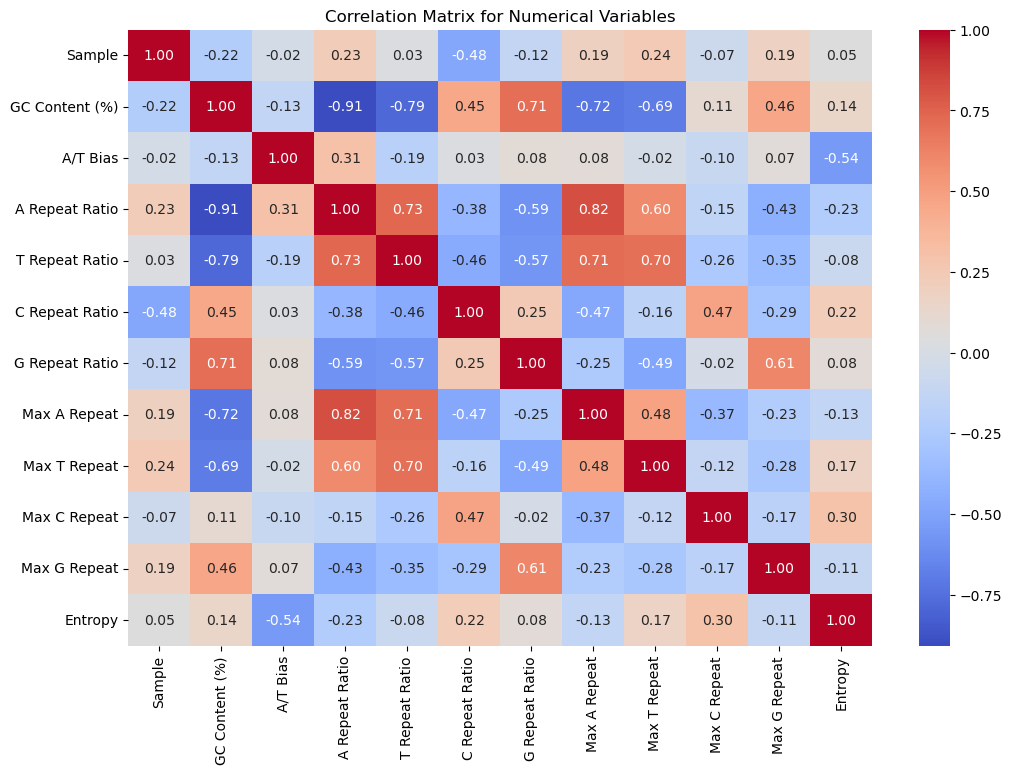

In [31]:
# 选择数值型列进行相关性分析
numeric_data = df.select_dtypes(include=[np.number])

# 计算相关性矩阵
correlation_matrix = numeric_data.corr()

# 绘制相关性矩阵热图
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix for Numerical Variables')
plt.show()

In [40]:
print(df.columns)

Index(['Sample', 'GC Content (%)', 'A/T Bias', 'A Repeat Ratio',
       'T Repeat Ratio', 'C Repeat Ratio', 'G Repeat Ratio', 'Max A Repeat',
       'Max T Repeat', 'Max C Repeat', 'Max G Repeat', 'Entropy'],
      dtype='object')


GC Content (%)
High      11
Medium     6
Low        3
Name: count, dtype: int64


/Users/darkghost/anaconda3/envs/phy/lib/python3.9/site-packages/sklearn/model_selection/_split.py:737: UserWarning: The least populated class in y has only 2 members, which is less than n_splits=3.
  warnings.warn(


Best Parameters: {'rf__max_depth': 5, 'rf__min_samples_split': 2, 'rf__n_estimators': 50}
              precision    recall  f1-score   support

        High       0.67      1.00      0.80         2
         Low       1.00      1.00      1.00         1
      Medium       0.00      0.00      0.00         1

    accuracy                           0.75         4
   macro avg       0.56      0.67      0.60         4
weighted avg       0.58      0.75      0.65         4



/Users/darkghost/anaconda3/envs/phy/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/darkghost/anaconda3/envs/phy/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/darkghost/anaconda3/envs/phy/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(r

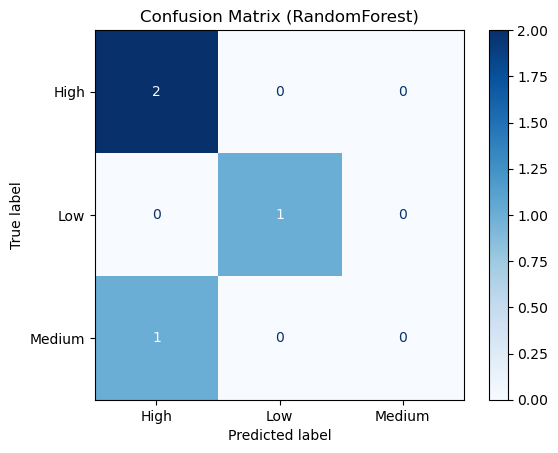

In [45]:
# 特征和目标
X = df.drop(columns=['Sample'])  # 去掉样本编号列
y = pd.cut(df['GC Content (%)'], bins=3, labels=["Low", "Medium", "High"])  # 通过GC含量分成3类

# 检查新目标变量的类别分布
print(y.value_counts())

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

# Define pipeline with scaling and RandomForest
pipeline = Pipeline([
    ('scaler', StandardScaler()),  
    ('rf', RandomForestClassifier(random_state=42))  
])

# Define hyperparameter grid for RandomForest
param_grid = {
    'rf__n_estimators': [50, 100, 200],
    'rf__max_depth': [5, 10, 20, None],
    'rf__min_samples_split': [2, 5, 10]
}

# Use GridSearchCV for hyperparameter tuning
rf_grid = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=3, scoring='accuracy')
rf_grid.fit(X_train, y_train)

# Best parameters
best_params = rf_grid.best_params_
print(f"Best Parameters: {best_params}")

# Predict on test set
y_pred = rf_grid.best_estimator_.predict(X_test)

# 输出分类报告
print(classification_report(y_test, y_pred))

# 绘制混淆矩阵
ConfusionMatrixDisplay.from_estimator(rf_grid, X_test, y_test, cmap='Blues')
plt.title('Confusion Matrix (RandomForest)')
plt.show()


Best Alpha: 500
RMSE: 7.8942
R²: -0.0269


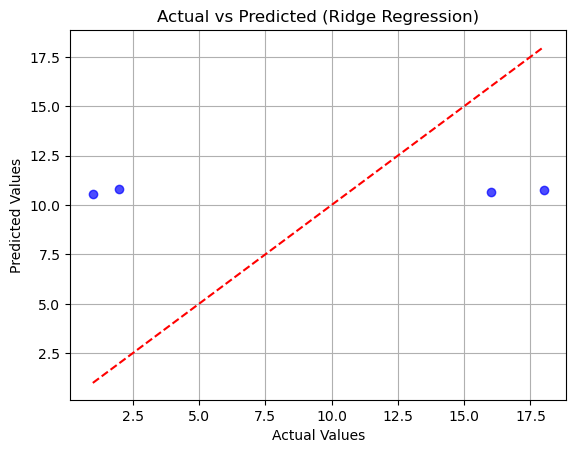

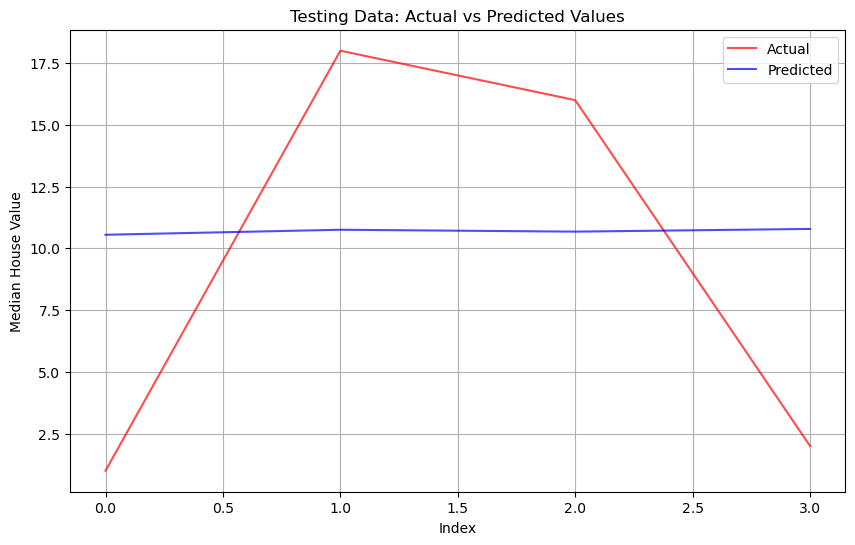

In [ ]:
from sklearn.model_selection import GridSearchCV, train_test_split
from sklearn.linear_model import Ridge
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import matplotlib.pyplot as plt

# 确保有数据集可用
# 这里假设你的 df 已经包含了特征和目标变量，并且目标变量是回归值，而不是分类标签
X = df.drop(columns=['Sample'])  # 假设目标列是 'Sample'
y = df['Sample']  # 目标列 'Sample'

# 划分训练集和测试集
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Define a pipeline with scaling and Ridge Regression
pipeline = Pipeline([
    ('scaler', StandardScaler()),  
    ('ridge', Ridge())             
])

# Define hyperparameter grid for alpha
param_grid = {
    'ridge__alpha': [0.01, 0.1, 1, 10, 100, 200, 500]
}

# Use GridSearchCV for hyperparameter tuning
ridge_grid = GridSearchCV(estimator=pipeline, param_grid=param_grid, cv=5, scoring='neg_mean_squared_error')
ridge_grid.fit(X_train, y_train)

# Best alpha value
best_alpha = ridge_grid.best_params_['ridge__alpha']
print(f"Best Alpha: {best_alpha}")

# Predict on test set
y_pred = ridge_grid.best_estimator_.predict(X_test)

# Calculate RMSE and R^2
mse = mean_squared_error(y_test, y_pred)
rmse_ridge = np.sqrt(mse)
r2_ridge = r2_score(y_test, y_pred)

print(f"RMSE: {rmse_ridge:.4f}")
print(f"R²: {r2_ridge:.4f}")

# Scatter plot for actual vs predicted
plt.scatter(y_test, y_pred, alpha=0.7, color='b')
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--')
plt.title('Actual vs Predicted (Ridge Regression)')
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.grid()
plt.show()

# Plot: Actual vs Predicted values
plt.figure(figsize=(10, 6))
plt.plot(range(len(y_test)), y_test, label="Actual", color="red", alpha=0.7)
plt.plot(range(len(y_pred)), y_pred, label="Predicted", color="blue", alpha=0.7)
plt.title("Testing Data: Actual vs Predicted Values")
plt.xlabel("Index")
plt.ylabel("Median House Value")
plt.legend()
plt.grid()
plt.show()
